In [229]:
import cv2
from draw_images import draw_images, convert_image_to_plt
from matplotlib import pyplot as plt
import numpy as np
import sys
sys.path.append('..')
import HomographicMatcher

In [230]:
def filter_image(img: np.ndarray):
    img_ret = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.GaussianBlur(img, (5, 5), 0)
    # img_ret = cv2.bilateralFilter(img_ret, 30, 30, 60)
    # img_ret = cv2.Canny(img_ret, 20, 40)
    return img_ret

In [231]:
model = cv2.imread('../res/input/target_hq.jpg')
frame = cv2.imread('./test_sample.jpg')

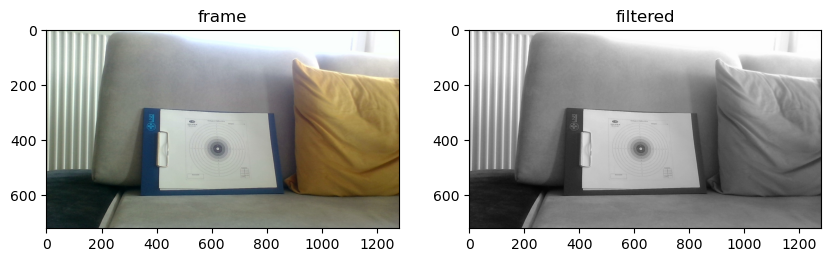

In [232]:
draw_images([
    ('frame', convert_image_to_plt(frame), None),
    ('filtered', convert_image_to_plt(filter_image(frame)), None)
], 1, 2, (10, 10))

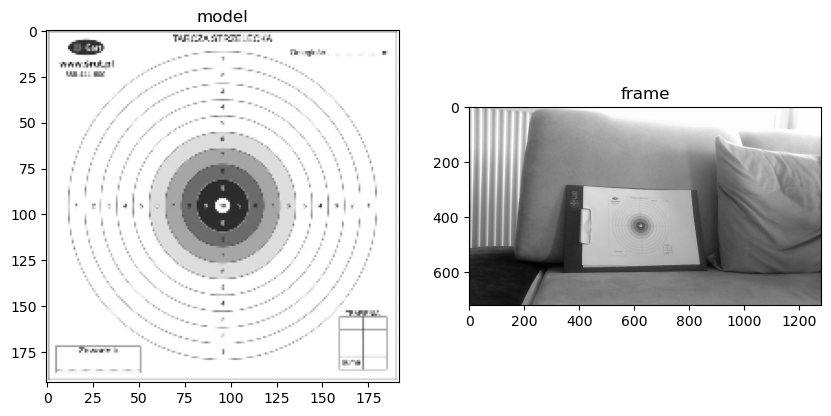

In [233]:
model_w, model_h, _ = model.shape
model_filtered = cv2.resize(model, (int(model_w*.3), int(model_h*.3)))
model_filtered = filter_image(model_filtered)
frame_filtered = filter_image(frame)

draw_images([
    ('model', model_filtered, 'gray'),
    ('frame', frame_filtered, 'gray')
], 1, 2, (10, 10))

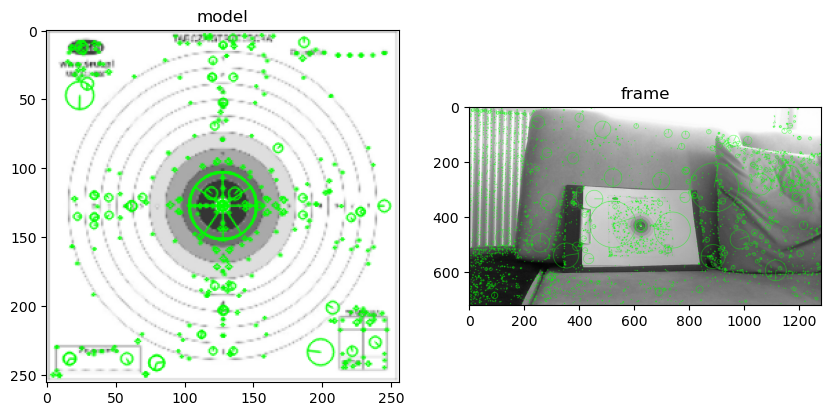

In [234]:
matcher: cv2.SIFT = cv2.SIFT_create(nfeatures=0, contrastThreshold=0.008, sigma=1.4)
model_filtered = cv2.resize(model_filtered, (int(model_w*.4), int(model_h*.4)))
model_kp, model_dsc = matcher.detectAndCompute(model_filtered, None)
frame_kp, frame_dsc = matcher.detectAndCompute(frame_filtered, None)

model_kp_img = cv2.drawKeypoints(model_filtered, model_kp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
frame_kp_img = cv2.drawKeypoints(frame_filtered, frame_kp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
draw_images([
    ('model', convert_image_to_plt(model_kp_img), None),
    ('frame', convert_image_to_plt(frame_kp_img), None)
], 1, 2, (10, 10))

best_matches len = 23


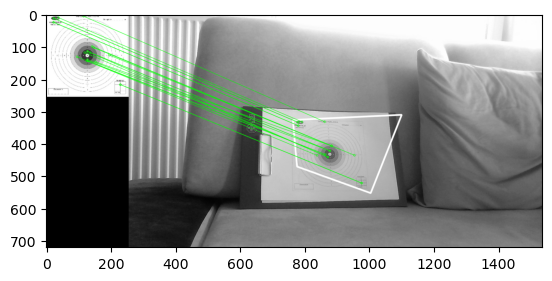

In [235]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(model_dsc, frame_dsc,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
print(f'best_matches len = {len(best_matches)}')
homography, mask = HomographicMatcher.calc_homography(model_kp, frame_kp, best_matches)
matchesMask = mask.ravel().tolist()
h,w = model_filtered.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
warped_transform = cv2.perspectiveTransform(pts, homography)
img2 = cv2.polylines(np.copy(frame_filtered), [np.int32(warped_transform)], True, 255, 3, cv2.LINE_AA)
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
    singlePointColor = None,
    matchesMask = matchesMask, # draw only inliers
    flags = 2
)
img3 = cv2.drawMatches(model_filtered, model_kp, img2, frame_kp, best_matches, None, **draw_params)
plt.imshow(convert_image_to_plt(img3))